In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import random

# Configuration matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print(" Imports réussis!")

 Imports réussis!


In [9]:
# Configuration des chemins
BASE_PATH = Path("../data/raw/ct_images")
TRAIN_IMAGES = BASE_PATH / "images" / "train"
TRAIN_LABELS = BASE_PATH / "labels" / "train"
VAL_IMAGES = BASE_PATH / "images" / "val"
VAL_LABELS = BASE_PATH / "labels" / "val"

# Vérification que les dossiers existent
print("📁 Vérification des chemins:")
print(f"Train images: {TRAIN_IMAGES.exists()} - {len(list(TRAIN_IMAGES.glob('*.jpg')))} images")
print(f"Train labels: {TRAIN_LABELS.exists()} - {len(list(TRAIN_LABELS.glob('*.txt')))} labels")
print(f"Val images: {VAL_IMAGES.exists()} - {len(list(VAL_IMAGES.glob('*.jpg')))} images")
print(f"Val labels: {VAL_LABELS.exists()} - {len(list(VAL_LABELS.glob('*.txt')))} labels")

📁 Vérification des chemins:
Train images: True - 239 images
Train labels: True - 249 labels
Val images: True - 41 images
Val labels: True - 41 labels


In [10]:
def read_yolo_label(label_path):
    """
    Lire un fichier label YOLO et convertir en coordonnées pixel

    Format YOLO: class_id center_x center_y width height (normalisé 0-1)
    Retourne: liste de bounding boxes en coordonnées pixel
    """
    boxes = []

    if not label_path.exists():
        return boxes

    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                boxes.append({
                    'class_id': class_id,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                })

    return boxes

# Test de la fonction
test_label = TRAIN_LABELS / "100_jpg.rf.16365de9284134e60df5a3bd27deb600.txt"
test_boxes = read_yolo_label(test_label)
print(f"📊 Test lecture label: {len(test_boxes)} nodule(s) détecté(s)")
if test_boxes:
    print(f"Premier nodule: {test_boxes[0]}")

📊 Test lecture label: 1 nodule(s) détecté(s)
Premier nodule: {'class_id': 1, 'center_x': 0.4483173076923077, 'center_y': 0.6538461538461539, 'width': 0.028846153846153848, 'height': 0.027644230769230768}


In [11]:
def yolo_to_pixel_coords(yolo_box, img_width, img_height):
    """
    Convertir coordonnées YOLO (0-1) en coordonnées pixel
    """
    center_x = yolo_box['center_x'] * img_width
    center_y = yolo_box['center_y'] * img_height
    width = yolo_box['width'] * img_width
    height = yolo_box['height'] * img_height

    # Calculer les coins de la bounding box
    x1 = int(center_x - width/2)
    y1 = int(center_y - height/2)
    x2 = int(center_x + width/2)
    y2 = int(center_y + height/2)

    return x1, y1, x2, y2

def draw_nodule_detection(image, boxes):
    """
    Dessiner les bounding boxes des nodules sur l'image avec OpenCV
    """
    img_copy = image.copy()
    height, width = image.shape[:2]

    for box in boxes:
        # Conversion YOLO → Pixel
        x1, y1, x2, y2 = yolo_to_pixel_coords(box, width, height)

        # Dessiner le rectangle (couleur verte pour nodule)
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Ajouter le label
        label = f"Nodule (Class {box['class_id']})"
        cv2.putText(img_copy, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return img_copy

print(" Fonctions de conversion et dessin créées!")

 Fonctions de conversion et dessin créées!


🖼️ Visualisation d'une image aléatoire:


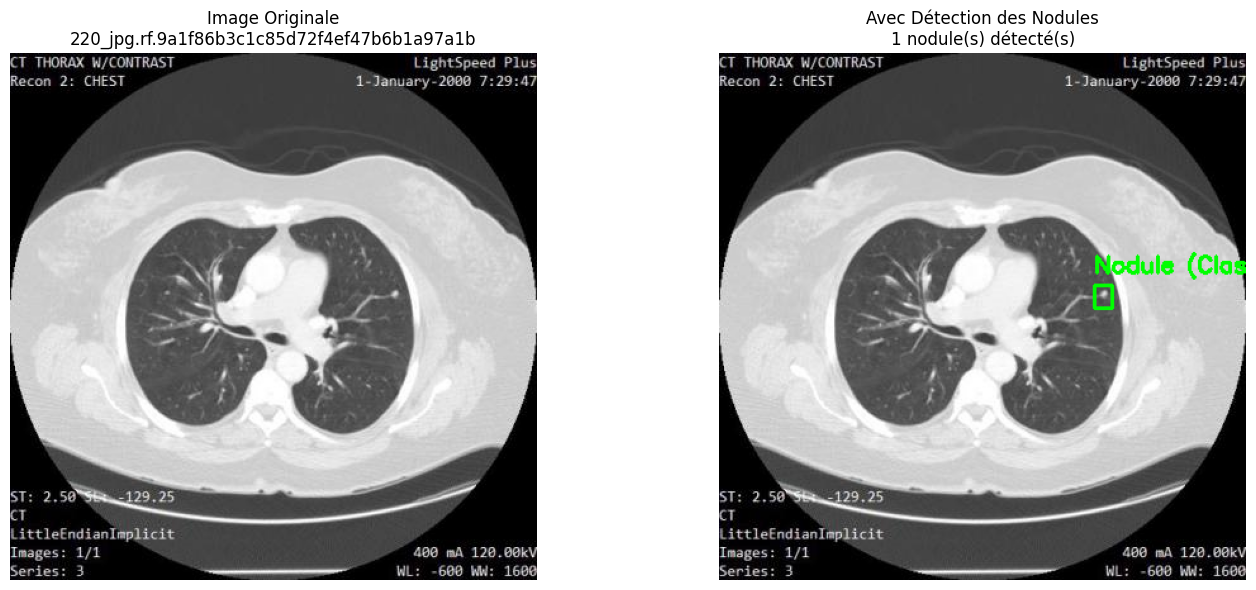

📊 Détails des 1 nodule(s):
  Nodule 1: Centre=(0.730, 0.463), Taille=(0.034, 0.043)


In [12]:
def visualize_sample(image_name=None, dataset='train'):
    """
    Visualiser une image avec ses nodules détectés
    """
    # Choisir les chemins selon le dataset
    if dataset == 'train':
        img_path = TRAIN_IMAGES
        label_path = TRAIN_LABELS
    else:
        img_path = VAL_IMAGES
        label_path = VAL_LABELS

    # Si pas de nom spécifié, prendre une image au hasard
    if image_name is None:
        image_files = list(img_path.glob('*.jpg'))
        if not image_files:
            print("❌ Aucune image trouvée!")
            return
        image_file = random.choice(image_files)
        image_name = image_file.stem

    # Chemins complets
    img_file = img_path / f"{image_name}.jpg"
    label_file = label_path / f"{image_name}.txt"

    # Vérifier que les fichiers existent
    if not img_file.exists():
        print(f"❌ Image non trouvée: {img_file}")
        return

    # Charger l'image
    image = cv2.imread(str(img_file))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Lire les labels
    boxes = read_yolo_label(label_file)

    # Dessiner les détections
    image_with_boxes = draw_nodule_detection(image_rgb, boxes)

    # Affichage
    plt.figure(figsize=(15, 6))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f'Image Originale\n{image_name}')
    plt.axis('off')

    # Image avec détections
    plt.subplot(1, 2, 2)
    plt.imshow(image_with_boxes)
    plt.title(f'Avec Détection des Nodules\n{len(boxes)} nodule(s) détecté(s)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Infos sur les nodules
    if boxes:
        print(f"📊 Détails des {len(boxes)} nodule(s):")
        for i, box in enumerate(boxes):
            print(f"  Nodule {i+1}: Centre=({box['center_x']:.3f}, {box['center_y']:.3f}), "
                  f"Taille=({box['width']:.3f}, {box['height']:.3f})")
    else:
        print("ℹ️ Aucun nodule détecté dans cette image")

# TEST: Visualiser une image aléatoire
print("🖼️ Visualisation d'une image aléatoire:")
visualize_sample()

In [13]:
# Explorer les images disponibles
def explore_dataset():
    """
    Explorer le contenu du dataset
    """
    print("📊 EXPLORATION DU DATASET")
    print("=" * 50)

    # Images train
    train_images = list(TRAIN_IMAGES.glob('*.jpg'))
    print(f"🔹 Images d'entraînement: {len(train_images)}")

    # Images val
    val_images = list(VAL_IMAGES.glob('*.jpg'))
    print(f"🔹 Images de validation: {len(val_images)}")

    print(f"\n📋 Exemples d'images train (5 premières):")
    for i, img in enumerate(train_images[:5]):
        print(f"  {i+1}. {img.name}")

    print(f"\n📋 Exemples d'images val (3 premières):")
    for i, img in enumerate(val_images[:3]):
        print(f"  {i+1}. {img.name}")

    return train_images, val_images

# Explorer
train_list, val_list = explore_dataset()

# Fonction pour visualiser une image spécifique
def visualize_specific_image(image_name):
    """
    Visualiser une image spécifique par son nom
    """
    # Supprimer l'extension si elle est présente
    if image_name.endswith('.jpg'):
        image_name = image_name[:-4]

    visualize_sample(image_name, 'train')

print(f"\n💡 Pour voir une image spécifique, utilise:")
print("visualize_specific_image('100_jpg.rf.16365de9284134e60df5a3bd27deb600')")

📊 EXPLORATION DU DATASET
🔹 Images d'entraînement: 239
🔹 Images de validation: 41

📋 Exemples d'images train (5 premières):
  1. 130_jpg.rf.989b67405305b7ed06c8447879b0b618.jpg
  2. 58_jpg.rf.23cd6fd88e81c6b6e88fa73ae229cbf6.jpg
  3. 249_jpg.rf.cdab3626404e496e1f05f7120b70d667.jpg
  4. 24_jpg.rf.92fdccd00471a8f2efd8347403a29311.jpg
  5. 80_jpg.rf.6b03dae79641206413b00fdfd1efc02a.jpg

📋 Exemples d'images val (3 premières):
  1. 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg
  2. 10_jpg.rf.c1785c33dd3552e860bf043c2fd0a379.jpg
  3. 3_jpg.rf.d2932cce7e88c2675e300ececf9f1b82.jpg

💡 Pour voir une image spécifique, utilise:
visualize_specific_image('100_jpg.rf.16365de9284134e60df5a3bd27deb600')


🖼️ Test de la première image train:


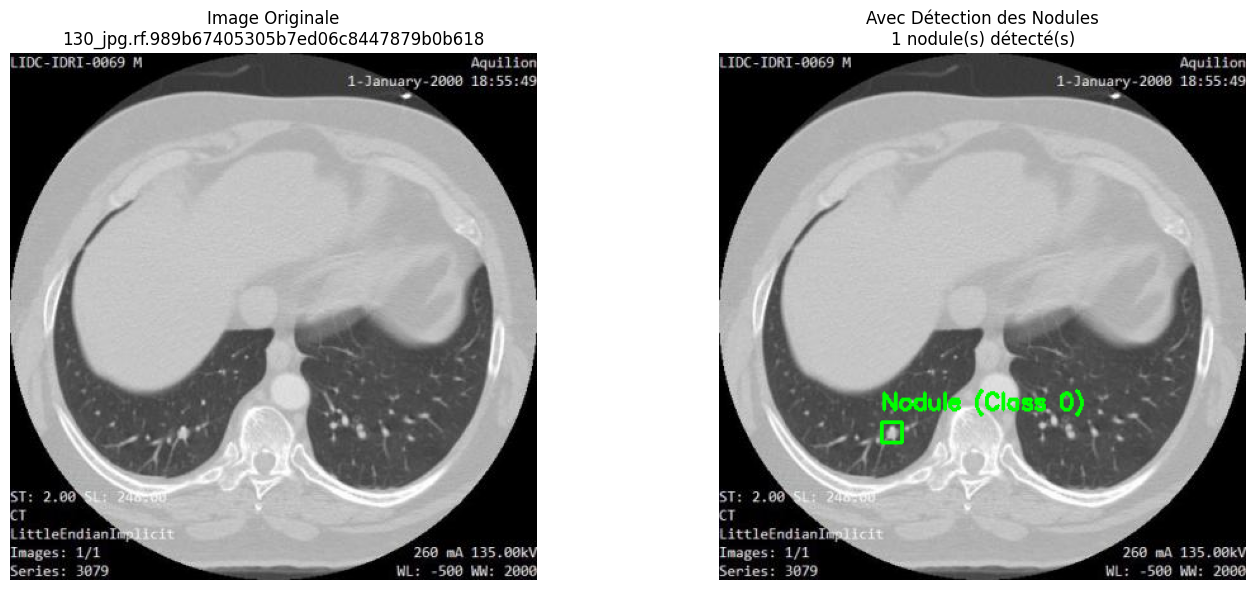

📊 Détails des 1 nodule(s):
  Nodule 1: Centre=(0.328, 0.720), Taille=(0.038, 0.037)


In [14]:
# Testons la première image de la liste
print("🖼️ Test de la première image train:")
visualize_specific_image('130_jpg.rf.989b67405305b7ed06c8447879b0b618')

In [15]:
# Analyser tous les labels pour comprendre le dataset
def analyze_dataset_stats():
    """
    Analyser les statistiques des nodules dans tout le dataset
    """
    all_boxes = []
    images_with_nodules = 0
    images_without_nodules = 0

    # Analyser train
    train_labels = list(TRAIN_LABELS.glob('*.txt'))
    for label_file in train_labels:
        boxes = read_yolo_label(label_file)
        if boxes:
            images_with_nodules += 1
            all_boxes.extend(boxes)
        else:
            images_without_nodules += 1

    # Analyser val
    val_labels = list(VAL_LABELS.glob('*.txt'))
    for label_file in val_labels:
        boxes = read_yolo_label(label_file)
        if boxes:
            images_with_nodules += 1
            all_boxes.extend(boxes)
        else:
            images_without_nodules += 1

    print("📊 STATISTIQUES DU DATASET")
    print("=" * 40)
    print(f"🔹 Images avec nodules: {images_with_nodules}")
    print(f"🔹 Images sans nodules: {images_without_nodules}")
    print(f"🔹 Total nodules détectés: {len(all_boxes)}")
    print(f"🔹 Pourcentage positif: {images_with_nodules/(images_with_nodules+images_without_nodules)*100:.1f}%")

    # Analyser les tailles des nodules
    if all_boxes:
        sizes = [box['width'] * box['height'] for box in all_boxes]
        print(f"\n📏 TAILLES DES NODULES:")
        print(f"🔹 Taille moyenne: {np.mean(sizes):.4f}")
        print(f"🔹 Taille min: {np.min(sizes):.4f}")
        print(f"🔹 Taille max: {np.max(sizes):.4f}")

analyze_dataset_stats()

📊 STATISTIQUES DU DATASET
🔹 Images avec nodules: 290
🔹 Images sans nodules: 0
🔹 Total nodules détectés: 305
🔹 Pourcentage positif: 100.0%

📏 TAILLES DES NODULES:
🔹 Taille moyenne: 0.0020
🔹 Taille min: 0.0004
🔹 Taille max: 0.0068


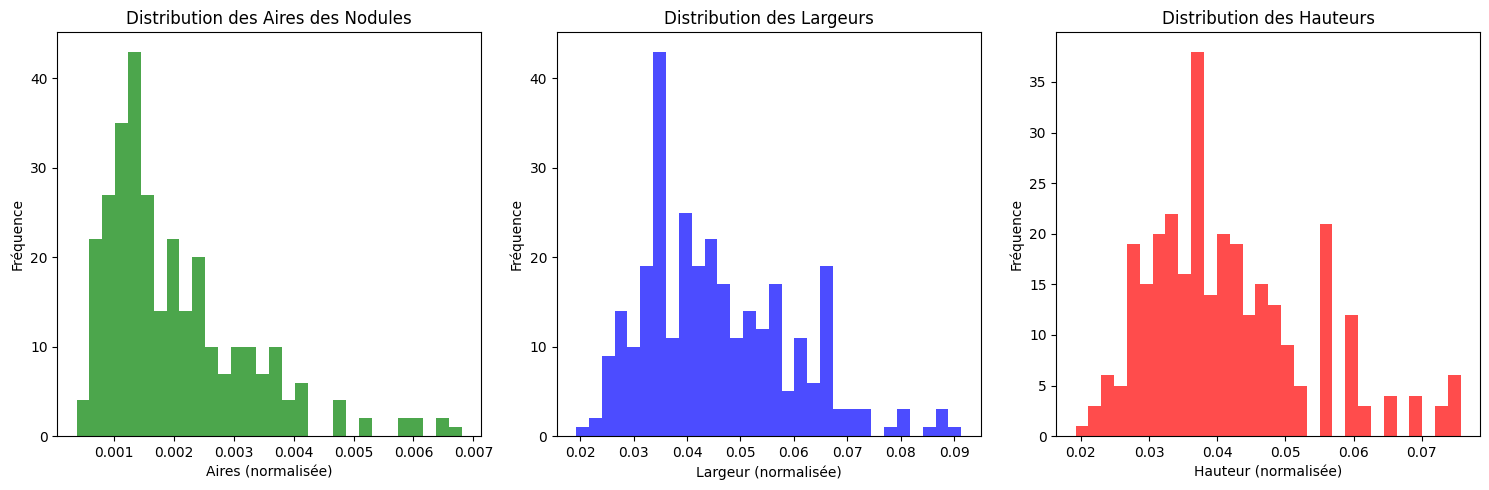

📏 Analyse détaillée:
🔹 53 nodules très petits (<0.1%)
🔹 9 nodules grands (>0.5%)


In [16]:
# Visualiser la distribution des tailles de nodules
def plot_nodule_size_distribution():
    """
    Graphique de la distribution des tailles des nodules
    """
    all_boxes = []

    # Collecter tous les nodules
    for label_file in list(TRAIN_LABELS.glob('*.txt')) + list(VAL_LABELS.glob('*.txt')):
        boxes = read_yolo_label(label_file)
        all_boxes.extend(boxes)

    # Calculer les tailles
    sizes = [box['width'] * box['height'] for box in all_boxes]
    widths = [box['width'] for box in all_boxes]
    heights = [box['height'] for box in all_boxes]

    # Graphiques
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(sizes, bins=30, alpha=0.7, color='green')
    plt.title('Distribution des Aires des Nodules')
    plt.xlabel('Aires (normalisée)')
    plt.ylabel('Fréquence')

    plt.subplot(1, 3, 2)
    plt.hist(widths, bins=30, alpha=0.7, color='blue')
    plt.title('Distribution des Largeurs')
    plt.xlabel('Largeur (normalisée)')
    plt.ylabel('Fréquence')

    plt.subplot(1, 3, 3)
    plt.hist(heights, bins=30, alpha=0.7, color='red')
    plt.title('Distribution des Hauteurs')
    plt.xlabel('Hauteur (normalisée)')
    plt.ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

    print(f"📏 Analyse détaillée:")
    print(f"🔹 {len([s for s in sizes if s < 0.001])} nodules très petits (<0.1%)")
    print(f"🔹 {len([s for s in sizes if s > 0.005])} nodules grands (>0.5%)")

plot_nodule_size_distribution()